In [1]:
import pandas as pd
from pandas import Timestamp as tmpstemp
from pandas import Timedelta as tmpdelta
import cbpro
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

from portfolio import Portfolio, Asset

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_112794/1645487527.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-04-20 16:30:39.703608: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
USD = Asset('USD')
date_range = pd.date_range(start=tmpstemp.fromisoformat('2000-01-01'), end=tmpstemp.today())
idx =pd.DatetimeIndex(date_range, name = 'date_time')
USD_2000 = pd.DataFrame({'low':[1] * len(idx), 'high':[1] * len(idx),
                    'open':[1] * len(idx), 'close':[1] * len(idx),
                    'volume':[1000]* len(idx)},
                     index=idx)
USD.update_history(USD_2000)

In [3]:
with open('CoinBaseAPIKey.key', 'r') as f:
    contents = f.readlines()
cb_key = contents[0].split(':')[-1].strip()
cb_secret = contents[1].split(':')[-1].strip()

In [4]:
#Download data
public_client = cbpro.PublicClient()
slots = [('2023-01-01', '2023-06-01'), ('2022-07-01', '2022-12-31'), ('2022-01-01', '2022-06-30'), ('2023-06-02', '2023-12-01')]
BTC = Asset('BTC')
ETH = Asset('ETH')
USDT = Asset('USDT')

for slot in slots:
    BTC_USD = public_client.get_product_historic_rates('BTC-USD', slot[0], slot[1], 86400)
    ETH_USD = public_client.get_product_historic_rates('ETH-USD', slot[0], slot[1], 86400)
    USDT_USD = public_client.get_product_historic_rates('USDT-USD', slot[0], slot[1], 86400)
    btc_data= pd.DataFrame(BTC_USD)
    btc_data.columns = [ 'date_time', 'low', 'high', 'open', 'close', 'volume' ]
    btc_data['date_time']= btc_data['date_time'].apply(lambda x: tmpstemp.fromtimestamp(x))
    btc_data.set_index('date_time', inplace=True)
    BTC.update_history(btc_data)

    ETH_data= pd.DataFrame(ETH_USD)
    ETH_data.columns = [ 'date_time', 'low', 'high', 'open', 'close', 'volume' ]
    ETH_data['date_time']= ETH_data['date_time'].apply(lambda x: tmpstemp.fromtimestamp(x))
    ETH_data.set_index('date_time', inplace=True)
    ETH.update_history(ETH_data)

    USDT_data= pd.DataFrame(USDT_USD)
    USDT_data.columns = [ 'date_time', 'low', 'high', 'open', 'close', 'volume' ]
    USDT_data['date_time']= USDT_data['date_time'].apply(lambda x: tmpstemp.fromtimestamp(x))
    USDT_data.set_index('date_time', inplace=True)
    USDT.update_history(USDT_data)

In [5]:
my_portfolio = Portfolio(origination_date=tmpstemp.fromisoformat('2021-12-01'), initial_deposit=10000)
my_portfolio.update_transactions(ticker='BTC', qty=1, transaction_date=tmpstemp.fromisoformat('2022-01-01'))
my_portfolio.update_transactions(ticker='USDT', qty=40000, transaction_date=tmpstemp.fromisoformat('2022-01-01'))

change             note
date_time  ticker                         
2021-12-01 USD        100  Initial deposit
2022-01-01 BTC          1                 
           USDT     40000                 
2022-01-02 BTC       -0.5                 
           USDT    -10000                 
2022-01-10 BTC      -0.25                 
           USDT    -20000

In [ ]:
class Strategy:

    def __init__(self, model):
        self.frequency = 1
        self.model = model
        self.input_span = 15

    def suggest_decision(self, portfolio: Portfolio):
        '''
        Returns a datframe with the suggested updates to portfolio
        '''
        delta_df = pd.DataFrame()
        return delta_df

    def backtest(self, hist_data: pd.DataFrame, portfolio: Portfolio):
        updated_portfolio = Portfolio()
        return updated_portfolio
    
    def train_val_split_scale(df):
        scaler  = MinMaxScaler(feature_range=(0,1))

        len_train = int(0.7*len(df))
        len_test = len(df) - len_train
        last_date_train = df.index[len_train]
        first_date_val = df.index[len_train+1]
        X = []
        y = []
        scaled_data = scaler.fit_transform(np.array(df['close'].values).reshape(-1,1) )
        for x in range(self.input_span, len(df)):
            X.append(scaled_data[x-self.input_span:x, 0])
            y.append(scaled_data[x,0])
        X, y = (np.array(X), np.array(y))
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))
        print(X.shape)
        return X[0:len_train,:,:], y[0:len_train,:,:], X[len_train:,:,:], y[len_train:,:,:]

    def make_model():
        return model


In [63]:
def train_val_split_scale(df, scaler, input_span):
    len_train = int(0.7*len(df))
    print(f'len_train {len_train}')
    len_test = len(df) - len_train
    last_date_train = df.index[len_train]
    first_date_val = df.index[len_train+1]
    X = []
    y = []
    scaled_data = scaler.fit_transform(np.array(df['close'].values).reshape(-1,1) )
    for x in range(input_span, len(df)):
        X.append(scaled_data[x-input_span:x, 0])
        y.append(scaled_data[x,0])
    X, y = (np.array(X), np.array(y))
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    print(X.shape)
    print(y.shape)
    train_idx = df.index[input_span:len_train]
    val_index = df.index[len_train:]
    print(f'from {train_idx[0]} to {train_idx[-1]}')
    return X[0:len_train-input_span,:,:], y[0:len_train-input_span], train_idx, X[len_train-input_span:,:,:], y[len_train-input_span:], val_index


In [64]:
input_span = 15
scaler  = MinMaxScaler(feature_range=(0,1))
x_train, y_train, train_idx, x_val, y_val, val_idx = train_val_split_scale(BTC.history, scaler, input_span)

len_train 489
(685, 15, 1)
(685,)
from 2022-01-15 19:00:00 to 2023-05-03 20:00:00


In [25]:
# Create, compile, train the model
model = Sequential()
model.add(LSTM(units = 50, activation='tanh', return_sequences=True, input_shape = (x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
optimizer = Adam(learning_rate=0.001, name='Adam')

model.compile(optimizer = optimizer, loss = 'mse', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=20, batch_size=8)

2024-04-20 21:21:43.037683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-20 21:21:43.039696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-20 21:21:43.041844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-04-20 21:21:43.572214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-20 21:21:43.575315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-20 21:21:43.577683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

62/62 [==============================] - 12s 71ms/step - loss: 0.0242 - accuracy: 0.0020
Epoch 2/20
62/62 [==============================] - 6s 102ms/step - loss: 0.0091 - accuracy: 0.0020
Epoch 3/20
62/62 [==============================] - 6s 90ms/step - loss: 0.0081 - accuracy: 0.0020
Epoch 4/20
62/62 [==============================] - 6s 99ms/step - loss: 0.0075 - accuracy: 0.0020
Epoch 5/20
62/62 [==============================] - 7s 106ms/step - loss: 0.0069 - accuracy: 0.0020
Epoch 6/20
62/62 [==============================] - 6s 103ms/step - loss: 0.0071 - accuracy: 0.0020
Epoch 7/20
62/62 [==============================] - 7s 106ms/step - loss: 0.0064 - accuracy: 0.0020
Epoch 8/20
62/62 [==============================] - 5s 85ms/step - loss: 0.0067 - accuracy: 0.0020
Epoch 9/20
62/62 [==============================] - 6s 102ms/step - loss: 0.0059 - accuracy: 0.0020
Epoch 10/20
62/62 [==============================] - 6s 103ms/step - loss: 0.0070 - accuracy: 0.0020
Epoch 11/20
6

In [ ]:
prediction_prices = []
# Given the new data go one time point after another and make predictions 
for x in range(len(val_idx)):
    model_input = x_val[x,:,:]                       # Data shaped as input for the model
    pred_BTC_price = model.predict(model_input,verbose = 0)                                # Predict
    pred_BTC_price = scaler.inverse_transform(pred_BTC_price)[0][0]                        # Un-scale to get predicted asset price
    prediction_prices.append(pred_BTC_price)                                               # Save the result in the output array

    # Format string for output
    predicted_for_date = val_idx[x]                   # Get date we are predictig for 
    curr_BTC_price = BTC.history.loc[val_idx[x]]                                             # Get current asset price 
    print(f'Today ({val_idx[x]}):{curr_BTC_price}, predicted for {predicted_for_date}: {pred_BTC_price}')

In [84]:
pred_BTC_price = model.predict(x_val[0,:,:],verbose = 0)
pred_BTC_price

TypeError: in user code:

    File "/home/art_usr/miniconda3/envs/crypto/lib/python3.9/site-packages/keras/engine/training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "/home/art_usr/miniconda3/envs/crypto/lib/python3.9/site-packages/keras/engine/training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/art_usr/miniconda3/envs/crypto/lib/python3.9/site-packages/keras/engine/training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "/home/art_usr/miniconda3/envs/crypto/lib/python3.9/site-packages/keras/engine/training.py", line 2111, in predict_step
        return self(x, training=False)
    File "/home/art_usr/miniconda3/envs/crypto/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/art_usr/miniconda3/envs/crypto/lib/python3.9/site-packages/keras/layers/rnn/lstm.py", line 615, in call
        timesteps = input_shape[0] if self.time_major else input_shape[1]

    TypeError: Exception encountered when calling layer 'lstm_3' (type LSTM).
    
    'NoneType' object is not subscriptable
    
    Call arguments received by layer 'lstm_3' (type LSTM):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
      • mask=None
      • training=False
      • initial_state=None


In [80]:
len_train = int(0.7*len(BTC.history))
len_test = len(BTC.history) - len_train
last_date_train = BTC.history.index[len_train]
first_date_val = BTC.history.index[len_train+1]

input_data = BTC.history['close'].loc[first_date_val-tmpdelta(days=input_span):]
prediction_prices = []
# Given the new data go one time point after another and make predictions 
for curr_date in input_data.index[(input_span-1):]:
    current_day_input = input_data[curr_date - tmpdelta(days=input_span-1):curr_date] # Data slice to be used in this step
    model_input = scaler.transform(np.array(current_day_input.values).reshape(-1,1) )  # Data scaled as input for the model
    model_input = np.array(model_input).reshape(1,input_span,1)                       # Data shaped as input for the model
    pred_BTC_price = model.predict(model_input,verbose = 0)                                # Predict
    pred_BTC_price = scaler.inverse_transform(pred_BTC_price)[0][0]                        # Un-scale to get predicted asset price
    prediction_prices.append(pred_BTC_price)                                               # Save the result in the output array

    # Format string for output
    predicted_for_date = current_day_input.index[-1]+tmpdelta(days=1)                      # Get date we are predictig for 
    curr_BTC_price = input_data.loc[curr_date]                                             # Get current asset price 
    print(f'Today ({curr_date}):{curr_BTC_price}, predicted for {predicted_for_date}: {pred_BTC_price}')
 
    '''
    current_positions = my_portfolio.get_positions(curr_date)
    if pred_BTC_price > curr_BTC_price:
        my_portfolio.update_transactions(ticker='BTC',
                                    qty = 0.01 * current_positions.loc['BTC', 'position_size'],
                                    transaction_date=curr_date)
    '''

Today (2023-05-04 20:00:00):29536.76, predicted for 2023-05-05 20:00:00: 28879.224609375
Today (2023-05-05 20:00:00):28902.66, predicted for 2023-05-06 20:00:00: 28939.353515625
Today (2023-05-06 20:00:00):28474.53, predicted for 2023-05-07 20:00:00: 28917.615234375
Today (2023-05-07 20:00:00):27695.06, predicted for 2023-05-08 20:00:00: 28754.3515625
Today (2023-05-08 20:00:00):27647.29, predicted for 2023-05-09 20:00:00: 28514.666015625
Today (2023-05-09 20:00:00):27624.01, predicted for 2023-05-10 20:00:00: 28259.568359375
Today (2023-05-10 20:00:00):26986.56, predicted for 2023-05-11 20:00:00: 27979.587890625
Today (2023-05-11 20:00:00):26808.84, predicted for 2023-05-12 20:00:00: 27691.19921875
Today (2023-05-12 20:00:00):26789.48, predicted for 2023-05-13 20:00:00: 27427.388671875
Today (2023-05-13 20:00:00):26929.98, predicted for 2023-05-14 20:00:00: 27218.076171875
Today (2023-05-14 20:00:00):27171.13, predicted for 2023-05-15 20:00:00: 27088.23828125
Today (2023-05-15 20:00:0

In [82]:
curr_date = input_data.index[(input_span-1)]
current_day_input = input_data[curr_date - tmpdelta(days=input_span-1):curr_date]
model_input = scaler.transform(np.array(current_day_input.values).reshape(-1,1) )  # Data scaled as input for the model
model_input = np.array(model_input).reshape(1,input_span,1) 
model_input


array([[[0.        ],
        [0.24861252],
        [0.14855163],
        [0.11441537],
        [0.46018897],
        [0.5134806 ],
        [0.9767665 ],
        [0.91321165],
        [0.87410367],
        [0.8731356 ],
        [0.36068877],
        [0.62663443],
        [0.78185299],
        [0.70234043],
        [1.        ]]])

array([[[0.        ],
        [0.24861252],
        [0.14855163],
        [0.11441537],
        [0.46018897],
        [0.5134806 ],
        [0.9767665 ],
        [0.91321165],
        [0.87410367],
        [0.8731356 ],
        [0.36068877],
        [0.62663443],
        [0.78185299],
        [0.70234043],
        [1.        ]]])

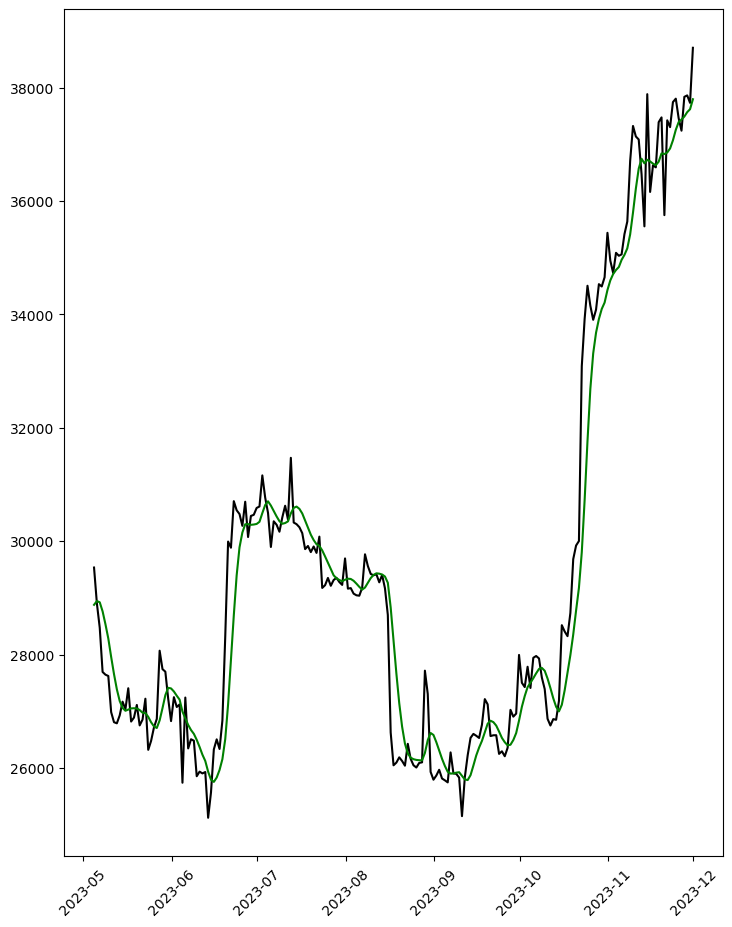

In [28]:
# Make data frame for final plotting
pred_df = pd.DataFrame(prediction_prices)
pred_df.columns = ['BTC_predicted']
plot_test = pd.concat([BTC.history.iloc[len_train:].reset_index(), pred_df[['BTC_predicted']].reset_index()], axis=1)

# Plot the results
fig, ax = plt.subplots(1, 1, sharex = True)
fig.set_figheight(11)
fig.set_figwidth(8.5)
ax.plot(plot_test['date_time'], plot_test['close'], color = 'black', label = 'Historic price')
ax.plot(plot_test['date_time'], plot_test['BTC_predicted'], color = 'green', label = 'Historic price')
for tick in ax.get_xticklabels():
        tick.set_rotation(45)